# 1.Import zbioru danych

In [1]:
#import bibliotek
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas as pd
import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import nltk

from textblob import TextBlob

import numpy as np

In [2]:
#pobierz słowa ze stoplisty
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')

#pobierz Punkt Tokenizer Models
nltk.download('punkt')

#pobierz angielską bazę danych rzeczowników, czasowników, przymiotników, przysłówków i zaimków
from textblob import Word
nltk.download('wordnet')

#pobierz Greedy Averaged Perceptron tagger
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mxnog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mxnog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mxnog\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mxnog\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
#załaduj zbiór danych
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')
#połączenie zbiorów w jeden w celu późniejszego podziału według potrzeby programu
train = pd.concat([train,test])
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [4]:
#zredukuj opcje do 3 (pozytywna, negatywna i neutralna)

train["Sentiment"] = train["Sentiment"].astype(str)

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
train['Sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,negative


In [5]:
train['text']=train.OriginalTweet
train['text']=train['text'].astype(str)
sentiment = train.groupby('Sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
sentiment=sentiment.set_index('Sentiment')
sentiment

,text
Sentiment,
positive,19592
negative,17031
neutral,8332


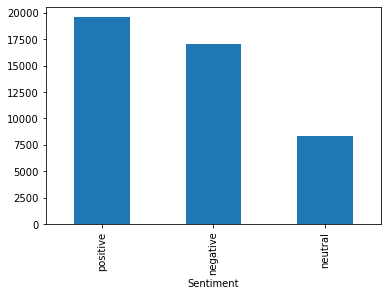

In [6]:
sentiment.plot(kind="bar", legend=None)

In [7]:
#wyświetl 100 rekordów
print(train.head(100))
#wyświetl informacje o zbiorze danych
print(train.describe())

    UserName  ScreenName                    Location     TweetAt  \
0       3799       48751                      London  16-03-2020   
1       3800       48752                          UK  16-03-2020   
2       3801       48753                   Vagabonds  16-03-2020   
3       3802       48754                         NaN  16-03-2020   
4       3803       48755                         NaN  16-03-2020   
..       ...         ...                         ...         ...   
95      3894       48846  FREE goal setting guide ??  16-03-2020   
96      3895       48847              Washington, DC  16-03-2020   
97      3896       48848              Washington, DC  16-03-2020   
98      3897       48849       San Joaquin Valley CA  16-03-2020   
99      3898       48850                Planet Earth  16-03-2020   

                                        OriginalTweet Sentiment  \
0   @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   neutral   
1   advice Talk to your neighbours family to exch

## 1.2 Analiza zbioru danych

In [8]:
#sprawdź liczbę słów w tweecie
train['word_count']=train['OriginalTweet'].apply(lambda x: len(str(x).split(" ")))
train[['OriginalTweet', 'word_count']].head(10)

,OriginalTweet,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,40
4,"Me, ready to go at supermarket during the #COV...",38
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,12
8,Due to COVID-19 our retail store and classroom...,46
9,"For corona prevention,we should stop to buy th...",42


In [9]:
#sprawdź ilość znaków
train['char_count']=train['OriginalTweet'].str.len()
train[['OriginalTweet', 'char_count']].head(10)

,OriginalTweet,char_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,111
1,advice Talk to your neighbours family to excha...,237
2,Coronavirus Australia: Woolworths to give elde...,131
3,My food stock is not the only one which is emp...,306
4,"Me, ready to go at supermarket during the #COV...",310
5,As news of the regionÂs first confirmed COVID...,250
6,Cashier at grocery store was sharing his insig...,180
7,Was at the supermarket today. Didn't buy toile...,119
8,Due to COVID-19 our retail store and classroom...,280
9,"For corona prevention,we should stop to buy th...",267


In [10]:
#sprawdź średnią długość słowa
def avg_word(sentence):
    words=sentence.split()
    return (sum(len(word) for word in words)/len(words))
train['avg_words'] = train['OriginalTweet'].apply(lambda x:avg_word(x))
train[['OriginalTweet', 'avg_words']].head(10)

,OriginalTweet,avg_words
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,13.000000
1,advice Talk to your neighbours family to excha...,5.263158
2,Coronavirus Australia: Woolworths to give elde...,8.428571
3,My food stock is not the only one which is emp...,6.000000
4,"Me, ready to go at supermarket during the #COV...",6.525000
5,As news of the regionÂs first confirmed COVID...,5.972222
6,Cashier at grocery store was sharing his insig...,5.464286
7,Was at the supermarket today. Didn't buy toile...,7.846154
8,Due to COVID-19 our retail store and classroom...,5.222222
9,"For corona prevention,we should stop to buy th...",5.380952


In [11]:
#policz ilość słów ze stoplisty
train['stopwords']=train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['OriginalTweet', 'stopwords']].head(10)

,OriginalTweet,stopwords
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,11
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,14
4,"Me, ready to go at supermarket during the #COV...",13
5,As news of the regionÂs first confirmed COVID...,8
6,Cashier at grocery store was sharing his insig...,9
7,Was at the supermarket today. Didn't buy toile...,2
8,Due to COVID-19 our retail store and classroom...,18
9,"For corona prevention,we should stop to buy th...",16


In [12]:
#policz ilość znaków specjalnych
specialPatt=r"[^a-zA-Z0-9 ]"
train['special_characters']=train['OriginalTweet'].str.findall(specialPatt)
train['special_characters']=train['special_characters'].apply(lambda x: len(x))
train[['OriginalTweet', 'special_characters']].head(10)

,OriginalTweet,special_characters
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,19
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,8
3,My food stock is not the only one which is emp...,37
4,"Me, ready to go at supermarket during the #COV...",35
5,As news of the regionÂs first confirmed COVID...,15
6,Cashier at grocery store was sharing his insig...,12
7,Was at the supermarket today. Didn't buy toile...,18
8,Due to COVID-19 our retail store and classroom...,12
9,"For corona prevention,we should stop to buy th...",8


In [13]:
#policz ilość znaków numerycznych
train['numerics'] = train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train[['OriginalTweet', 'numerics']].head(10)

,OriginalTweet,numerics
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",0
5,As news of the regionÂs first confirmed COVID...,0
6,Cashier at grocery store was sharing his insig...,0
7,Was at the supermarket today. Didn't buy toile...,0
8,Due to COVID-19 our retail store and classroom...,0
9,"For corona prevention,we should stop to buy th...",0


In [14]:
#policz słowa z wielką literą
train['upper_count'] = train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isupper]))
train[['OriginalTweet', 'upper_count']].head(10)

,OriginalTweet,upper_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,42
4,"Me, ready to go at supermarket during the #COV...",40
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,13
8,Due to COVID-19 our retail store and classroom...,45
9,"For corona prevention,we should stop to buy th...",42


In [15]:
train.corr()

,UserName,ScreenName,word_count,char_count,avg_words,stopwords,special_characters,numerics,upper_count
UserName,1.000000,1.000000,-0.077938,-0.048285,0.044671,-0.093281,-0.027700,0.060658,-0.080956
ScreenName,1.000000,1.000000,-0.077938,-0.048285,0.044671,-0.093281,-0.027700,0.060658,-0.080956
word_count,-0.077938,-0.077938,1.000000,0.853798,-0.354407,0.847810,0.096506,0.172068,0.988438
char_count,-0.048285,-0.048285,0.853798,1.000000,-0.054861,0.601460,0.472355,0.038452,0.880358
avg_words,0.044671,0.044671,-0.354407,-0.054861,1.000000,-0.420707,0.301650,-0.159020,-0.343619
stopwords,-0.093281,-0.093281,0.847810,0.601460,-0.420707,1.000000,-0.121965,0.090218,0.843203
special_characters,-0.027700,-0.027700,0.096506,0.472355,0.301650,-0.121965,1.000000,-0.160979,0.164690
numerics,0.060658,0.060658,0.172068,0.038452,-0.159020,0.090218,-0.160979,1.000000,0.163199
upper_count,-0.080956,-0.080956,0.988438,0.880358,-0.343619,0.843203,0.164690,0.163199,1.000000


# 2. Normalizacja danych tekstowych

In [16]:
#kopia bez normalizacji
trainDFRaw = train.copy()
#usuń słowa z wielką literą
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https://t.co/i...
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
3    my food stock is not the only one which is emp...
4    me, ready to go at supermarket during the #cov...
5    as news of the regionâs first confirmed covid...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today. didn't buy toile...
8    due to covid-19 our retail store and classroom...
9    for corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

In [17]:
#usuń wszystkie znaki specjalne poza białymi
train['OriginalTweet'] = train['OriginalTweet'].str.replace("[^\w\s]", '')
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
5    as news of the regionâs first confirmed covid1...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today didnt buy toilet ...
8    due to covid19 our retail store and classroom ...
9    for corona preventionwe should stop to buy thi...
Name: OriginalTweet, dtype: object

In [18]:
#usuń słowa z ze stop listy
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please dont panic enough ...
4    ready go supermarket covid19 outbreak im paran...
5    news regionâs first confirmed covid19 case cam...
6    cashier grocery store sharing insights covid_1...
7    supermarket today didnt buy toilet paper rebel...
8    due covid19 retail store classroom atlanta ope...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [19]:
#przeanalizuj frazy najczęściej występujące
freq=pd.Series(' '.join(train['OriginalTweet']).split()).value_counts()[:5]
freq

coronavirus    19460
covid19        14551
food            8359
prices          8313
store           7784
dtype: int64

In [20]:
#usuń słowa najczęściej występujące
freq=list(freq.index)
train['OriginalTweet']= train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insights covid_19 prov...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [21]:
#przeanalizuj słowa najrzadziej występujące
leastFreq=pd.Series(' '.join(train['OriginalTweet']).split()).value_counts()[-30:]
leastFreq

10tampabay             1
boomed                 1
naseâ                  1
tuscany                1
httpstcokjzapoafj2     1
realestatelifeâ        1
httpstcoi4np5qp7af     1
munday                 1
tui                    1
awa                    1
httpstcoqm72dzdyco     1
fonu                   1
pricerise              1
hinshaw                1
amptv                  1
httpstcoizvmkae0w6     1
httpstcohxs3ueog4f     1
nedunaija              1
farmersareessential    1
httpstco4tjtzifngi     1
demandsupply           1
nextpissed             1
httpstcofsf8wsfjo2     1
httpstcoqn3iyi5fhi     1
httpstcokr5uw9pa7b     1
âold                   1
httpstcows6kmziek0     1
dxxkheads              1
anticorona             1
httpstcovpgmpxrgba     1
dtype: int64

In [22]:
#usuń słowa najrzadziej występujące
leastFreq= list(leastFreq.index)
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in leastFreq))
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insights covid_19 prov...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [23]:
#lematyzacja - zamiana słów na ich podstawową formę
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbour family exchange phone nu...
2    australia woolworth give elderly disabled dedi...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insight covid_19 prove...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy thing cash use on...
Name: OriginalTweet, dtype: object

In [24]:
t = pd.Series.to_string(train['OriginalTweet'])

In [25]:
import unittest
import string 
import re

class Analysis:
    def __init__(self, tweet: string):
        self.tweet = tweet 
        
    def isUpper(self):
        count = 0
        for word in self.tweet.split(" "):
            for char in word:
                if char.isupper():
                    print(char)
                    count += 1
        return count

 
    def isSpecial(self):
        count = 0
        specialPatt=r"[^\w\s]"
        for word in self.tweet.split(" "):
            for char in word:
                if re.fullmatch(char, specialPatt):
                    count +=1
        return count

class TestAnalysis(unittest.TestCase):

    def test_isupper(self):
        tweet = Analysis(t)
        isUpper = tweet.isUpper()
        self.assertEqual(0, isUpper)
        
    def test_isspecial(self):
        tweet = Analysis(t)
        isspecial = tweet.isSpecial()
        self.assertEqual(0, isspecial)
        

In [26]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_isspecial (__main__.TestAnalysis) ... ok
test_isupper (__main__.TestAnalysis) ... ok

----------------------------------------------------------------------
Ran 2 tests in 2.923s

OK


In [27]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

# 2.1 Wektoryzacja

In [28]:
tf1 = (train['OriginalTweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,phone,2
1,neighbour,2
2,number,2
3,gp,1
4,account,1
5,shopping,1
6,order,1
7,online,1
8,exchange,1
9,regular,1


In [29]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(train.shape[0]/(len(train[train['OriginalTweet'].str.contains(word)])))
tf1

,words,tf,idf
0,phone,2,5.082205
1,neighbour,2,6.003887
2,number,2,4.689970
3,gp,1,4.789161
4,account,1,5.583519
5,shopping,1,2.385691
6,order,1,3.545608
7,online,1,2.477792
8,exchange,1,6.602543
9,regular,1,5.271000


In [30]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,phone,2,5.082205,10.164411
1,neighbour,2,6.003887,12.007774
2,number,2,4.689970,9.379939
3,gp,1,4.789161,4.789161
4,account,1,5.583519,5.583519
5,shopping,1,2.385691,2.385691
6,order,1,3.545608,3.545608
7,online,1,2.477792,2.477792
8,exchange,1,6.602543,6.602543
9,regular,1,5.271000,5.271000


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(train['OriginalTweet'])

train_vect

<44955x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 406339 stored elements in Compressed Sparse Row format>

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(train['OriginalTweet'])
train_bow

<44955x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 453267 stored elements in Compressed Sparse Row format>

In [33]:
train['sentiment'] = train['OriginalTweet'].apply(lambda x: TextBlob(x).sentiment[0])
train[['OriginalTweet', 'sentiment']].head()

,OriginalTweet,sentiment
0,menyrbie phil_gahan chrisitv httpstcoifz9fan2p...,0.000000
1,advice talk neighbour family exchange phone nu...,0.166667
2,australia woolworth give elderly disabled dedi...,-0.200000
3,stock one empty please dont panic enough every...,0.175000
4,ready go supermarket outbreak im paranoid stoc...,-0.077778


In [34]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [35]:
from gensim.models import KeyedVectors 
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [36]:
tweets=np.array(train['OriginalTweet'])
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets)

vectorizer.get_feature_names()

['00',
 '000',
 '0000009375',
 '000042',
 '0000hrs',
 '0006',
 '000francs',
 '000s',
 '001',
 '0010',
 '0016',
 '0017âkwh',
 '0025450557',
 '0026691661',
 '005',
 '00541296',
 '0095',
 '00am',
 '00pm',
 '01',
 '010',
 '0100am',
 '0101',
 '0103641972',
 '0106',
 '0113',
 '0115',
 '012020',
 '0121',
 '01236',
 '01273',
 '0131',
 '01392576476infoswcommsenergycouk',
 '014',
 '01449',
 '0147',
 '01474',
 '01625',
 '0169061211',
 '017569',
 '01756986',
 '0175698634',
 '01765',
 '01892',
 '01952',
 '01hr',
 '01kg',
 '02',
 '020',
 '0200hrs',
 '02027790000202628233',
 '0203',
 '02037386000',
 '0207pm',
 '021111000162',
 '0214996028',
 '02268443322',
 '023',
 '024p',
 '025',
 '0258',
 '025pc',
 '027',
 '028',
 '02890391225',
 '029',
 '02920',
 '03',
 '0300',
 '0300pm',
 '03031239999',
 '03065659733',
 '03162020',
 '031820',
 '0319',
 '03202020',
 '032320',
 '03237979660',
 '03252020',
 '0330',
 '03338819977',
 '03344859556',
 '0337210852',
 '034',
 '0344',
 '0345',
 '03454',
 '0351',
 '036',
 '

# 3. Przygotowanie modelu

# Dane treningowe i testowe

In [37]:
#podział zbioru na dane testowe i treningowe
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train['OriginalTweet'], train['Sentiment'])

#zmiana etykiet na numeryczne
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
train_y.shape, train_x.shape

((33716,), (33716,))

# Liczba wystąpień słowa w tekście

In [38]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train['OriginalTweet'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)
print(xtrain_count)

  (0, 1935)	1
  (0, 8604)	1
  (0, 9056)	1
  (0, 9608)	2
  (0, 18715)	1
  (0, 25927)	1
  (0, 26052)	1
  (0, 57593)	1
  (0, 59332)	1
  (0, 63510)	1
  (0, 63975)	1
  (0, 64430)	2
  (0, 72865)	1
  (0, 74838)	1
  (0, 76313)	1
  (0, 78478)	1
  (0, 79967)	1
  (0, 82428)	1
  (0, 85064)	1
  (0, 85969)	1
  (1, 10382)	1
  (1, 11455)	1
  (1, 12477)	1
  (1, 19447)	1
  (1, 21515)	1
  :	:
  (33715, 5517)	1
  (33715, 6231)	1
  (33715, 6271)	1
  (33715, 7032)	1
  (33715, 12999)	1
  (33715, 13018)	1
  (33715, 14413)	1
  (33715, 17252)	1
  (33715, 17282)	1
  (33715, 21597)	1
  (33715, 23904)	1
  (33715, 31883)	1
  (33715, 32705)	1
  (33715, 54110)	1
  (33715, 56381)	1
  (33715, 60819)	1
  (33715, 60867)	1
  (33715, 66010)	1
  (33715, 67876)	2
  (33715, 67926)	1
  (33715, 70041)	1
  (33715, 74536)	1
  (33715, 75169)	1
  (33715, 79220)	1
  (33715, 80941)	1


# Częstotliwość faz i odwrócona częstotliwość faz

In [39]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train['OriginalTweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train['OriginalTweet'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(train['OriginalTweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


# Kodowanie słów

In [40]:
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec', encoding="utf-8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

token = text.Tokenizer()
token.fit_on_texts(train['OriginalTweet'])
word_index = token.word_index

train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# NLP features - liczba słów, liter, znaków interpunkcyjnych, słów z wielkimi literami, zaczynąjących się od wielkiej litery i średnia długiść słów

In [41]:
train['char_count'] = train['OriginalTweet'].apply(len)
train['word_count'] = train['OriginalTweet'].apply(lambda x: len(x.split()))
train['word_density'] = train['char_count'] / (train['word_count']+1)
train['punctuation_count'] = train['OriginalTweet'].apply(
    lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train['title_word_count'] = train['OriginalTweet'].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train['upper_case_word_count'] = train['OriginalTweet'].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

# Liczba rzeczowników, czasowników, przymiotników, przysłówków i zaimków

In [42]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adjective' :  ['JJ','JJR','JJS'],
    'adverb' : ['RB','RBR','RBS','WRB'],
    'pronoun' : ['PRP','PRP$','WP','WP$']
}

def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

train['noun_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'noun'))
train['verb_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'verb'))
train['adjective_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'adjective'))
train['adverb_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'adverb'))
train['pronoun_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'pronoun'))

In [43]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,word_count,char_count,avg_words,...,sentiment,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adjective_count,adverb_count,pronoun_count
0,3799,48751,London,16-03-2020,menyrbie phil_gahan chrisitv httpstcoifz9fan2p...,neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,6,85,13.000000,...,0.000000,12.142857,1,0,0,6,0,0,0,0
1,3800,48752,UK,16-03-2020,advice talk neighbour family exchange phone nu...,positive,advice Talk to your neighbours family to excha...,27,185,5.263158,...,0.166667,6.607143,0,0,0,17,4,4,0,0
2,3801,48753,Vagabonds,16-03-2020,australia woolworth give elderly disabled dedi...,positive,Coronavirus Australia: Woolworths to give elde...,11,98,8.428571,...,-0.200000,8.166667,0,0,0,3,5,2,0,0
3,3802,48754,NaN,16-03-2020,stock one empty please dont panic enough every...,positive,My food stock is not the only one which is emp...,20,168,6.000000,...,0.175000,8.000000,1,0,0,9,3,6,1,0
4,3803,48755,NaN,16-03-2020,ready go supermarket outbreak im paranoid stoc...,negative,"Me, ready to go at supermarket during the #COV...",21,185,6.525000,...,-0.077778,8.409091,0,0,0,12,2,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,meanwhile supermarket israel people dance sing...,positive,Meanwhile In A Supermarket in Israel -- People...,10,88,6.111111,...,0.227273,8.000000,0,0,0,4,2,2,2,0
3794,3795,48747,"Farmington, NM",16-03-2020,panic buy lot nonperishable item echo need don...,negative,Did you panic buy a lot of non-perishable item...,18,131,5.294118,...,0.500000,6.894737,0,0,0,11,3,3,1,0
3795,3796,48748,"Haverford, PA",16-03-2020,asst prof economics cconces nbcphiladelphia ta...,neutral,Asst Prof of Economics @cconces was on @NBCPhi...,14,119,6.153846,...,0.000000,7.933333,0,0,0,8,3,1,1,0
3796,3797,48749,NaN,16-03-2020,gov need somethings instead biar je rakyat ass...,negative,Gov need to do somethings instead of biar je r...,24,154,5.034483,...,-1.000000,6.160000,0,0,0,12,6,1,2,0


# Modelowanie abstrakcyjnych tematów

In [44]:
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
print(topic_summaries)

['consumer right quarantine china restaurant etc economic thanks economy spending', 'low gas hit distance discus app loan cnn texas trump', 'supermarket grocery covid_19 people get go like going think everyone', 'toiletpaper take never tip offer drug follow yesterday actually 15', 'good news panic making shortage buying hoarding panicbuying start continue', 'online shopping 19 covid amp consumer delivery business pandemic order', 'hand sanitizer outbreak line toilet last paper roll shopper price', 'helpful disinfect booming quarantineandchill grain pledge unilever planet toiletpaperchallenge coronavirusaustralia', 'case around ever question waiting patient walking airline hungry isolation', 'oil pandemic supply consumer market demand amid chain global impact', 'protection told stophoarding death higher basic announced become symptom mass', 'paper toilet consumer support month read change new scam american', 'via high since glove anyone price drop seeing old farmer', 'stock crisis u dem

# Modelowanie uczenia maszynowego

## Medoda sprawdzająca dokładność modelu

In [45]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    # dokonaj ewaluacji modelu na podstawie danych testowych
    scores = list(metrics.precision_recall_fscore_support(predictions, valid_y))
    score_vals = [
        scores[0][0],
        scores[1][0],
        scores[2][0]
    ]
    score_vals.append(metrics.accuracy_score(predictions, valid_y))
    return score_vals

## Naiwny klasyfikator Bayesowski

In [46]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab = {'NB':accuracy}
print ("NB, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  [0.7419056429232193, 0.6805260924904539, 0.7098915689311796, 0.6745262033988789]
NB, WordLevel TF-IDF:  [0.7123034227567068, 0.7054512139257902, 0.708860759493671, 0.6726577097606549]
NB, N-Gram Vectors:  [0.5113320999074931, 0.5897572686049614, 0.5477517651430696, 0.5464899012367649]
NB, CharLevel Vectors:  [0.5959759481961147, 0.6577335375191424, 0.6253336568793981, 0.6179375389269508]


## Klasyfikator liniowy

In [47]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab['LR'] =  accuracy
print ("LR, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  [0.7874653098982424, 0.8175270108043218, 0.8022146306985509, 0.7925972061571314]


C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, WordLevel TF-IDF:  [0.790009250693802, 0.8022545796148427, 0.7960848287112562, 0.7874366046801317]


C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, N-Gram Vectors:  [0.5, 0.5884594447468698, 0.5406351587896974, 0.5423970104101788]
LR, CharLevel Vectors:  [0.7053654024051804, 0.7174782404140202, 0.7113702623906706, 0.7006851143340155]


C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Klasyfikator Support Vector Machine

In [48]:
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy_compareTab['SVM'] =  accuracy
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  [0.6359851988899168, 0.5197505197505198, 0.5720228809152367, 0.5491591778627992]


## Klasyfikator Random Forrest, modele agregujące

In [49]:
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab['RF'] =  accuracy
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  [0.7069842738205365, 0.7963011200833551, 0.74898934215362, 0.7586084171189608]
RF, WordLevel TF-IDF:  [0.7039777983348752, 0.7681049709815796, 0.7346446241100519, 0.7395675771865824]


## Klasyfikator Extreme Boosting

In [50]:
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
accuracy_compareTab['Xgb'] =  accuracy
print ("Xgb, CharLevel Vectors: ", accuracy)

C:\Users\mxnog\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, Count Vectors:  [0.7180851063829787, 0.7937116564417178, 0.7540067994171927, 0.7620784767328054]
[20:10:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, WordLevel TF-IDF:  [0.7349676225716929, 0.772484200291687, 0.7532590661294146, 0.7553163092801851]
[20:11:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the

## Płytkie sieci neuronowe

In [51]:
def create_model_architecture(input_size):
    input_layer = layers.Input((input_size, ), sparse=True)

    hidden_layer = layers.Dense(100, activation="relu")(input_layer)

    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
accuracy_compareTab['NN'] =  accuracy
print ("NN, Ngram Level TF IDF Vectors",  accuracy)

1054/1054 [==============================] - 2s 2ms/step - loss: -1.8247: 1s  - ETA: 0s - - ETA: 0s -
NN, Ngram Level TF IDF Vectors [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353]


C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Głębokie sieci neuronowe

### Konwulcyjne sieci neuronowe

In [52]:
def create_cnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['CNN'] =  accuracy
print ("CNN, Word Embeddings",  accuracy)

1054/1054 [==============================] - 9s 8ms/step - loss: -1360.8311
CNN, Word Embeddings [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353]


### Long Short Term Model

In [53]:
def create_rnn_lstm():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.LSTM(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)
accuracy_compareTab['RNN-LSTM'] =  accuracy

1054/1054 [==============================] - 28s 27ms/step - loss: -14.5814
RNN-LSTM, Word Embeddings [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353]


### Granted Recurrent Unit

In [54]:
def create_rnn_gru():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.GRU(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RNN-GRU'] =  accuracy
print ("RNN-GRU, Word Embeddings",  accuracy)

1054/1054 [==============================] - 29s 27ms/step - loss: -17.6344
RNN-GRU, Word Embeddings [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353]


### Dwukierunkowe sieci neuronowe

In [55]:
def create_bidirectional_rnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RNN-Bidirectional'] =  accuracy
print ("RNN-Bidirectional, Word Embeddings",  accuracy)

1054/1054 [==============================] - 33s 31ms/step - loss: -73.6242
RNN-Bidirectional, Word Embeddings [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353]


### Rekurencyjne konwolucyjne sieci neuronowe

In [56]:
def create_rcnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RCNN'] =  accuracy
print ("RCNN, Word Embeddings",  accuracy)

1054/1054 [==============================] - 8s 8ms/step - loss: -1071.4106
RCNN, Word Embeddings [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353]


In [57]:
print(accuracy_compareTab)
accuracy_compareTab2 = accuracy_compareTab.copy()
print(accuracy_compareTab2)

{'NB': [0.7123034227567068, 0.7054512139257902, 0.708860759493671, 0.6726577097606549], 'LR': [0.790009250693802, 0.8022545796148427, 0.7960848287112562, 0.7874366046801317], 'SVM': [0.6359851988899168, 0.5197505197505198, 0.5720228809152367, 0.5491591778627992], 'RF': [0.7039777983348752, 0.7681049709815796, 0.7346446241100519, 0.7395675771865824], 'Xgb': [0.7074468085106383, 0.7328701485385721, 0.7199341021416804, 0.7117181243882907], 'NN': [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353], 'CNN': [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353], 'RNN-LSTM': [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353], 'RNN-GRU': [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353], 'RNN-Bidirectional': [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353], 'RCNN': [1.0, 0.38473173769908353, 0.5556769260425368, 0.38473173769908353]}
{'NB': [0.7123034227567068, 0.7054512139257902, 0.708860759493671, 0.67265770976

# 4.Ewaluacja modeli

In [58]:
%matplotlib notebook

<IPython.core.display.Javascript object>


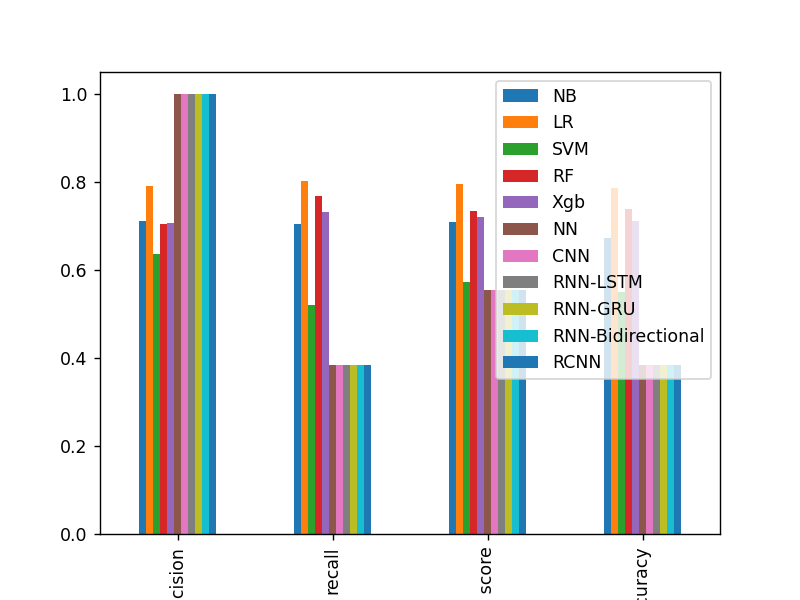

In [59]:
df_compare = pd.DataFrame(accuracy_compareTab, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')

## Dane bez normalizacji tekstu

In [60]:
#podział zbioru na dane testowe i treningowe
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDFRaw['OriginalTweet'], trainDFRaw['Sentiment'])

#zmiana etykiet na numeryczne
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Klasyfikatory

In [61]:
#NB
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2 = {'NBRaw':accuracy}

In [62]:
#LR
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2['LRRaw'] =  accuracy

C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
#SVM
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy_compareTab2['SVMRaw'] =  accuracy

In [64]:
#RF
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2['RFRaw'] =  accuracy

In [65]:
#Xgb
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
accuracy_compareTab2['XgbRaw'] =  accuracy

C:\Users\mxnog\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>


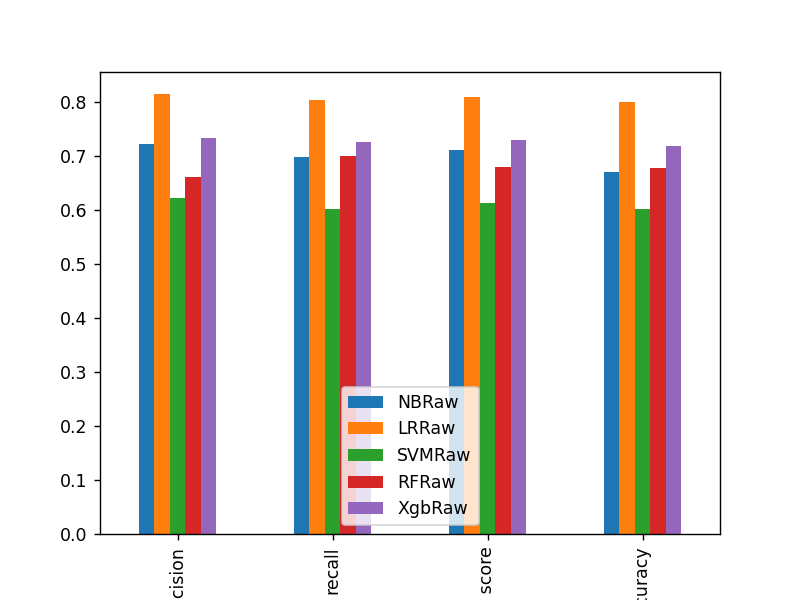

In [66]:
df_compare2 = pd.DataFrame(accuracy_compareTab2, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare2.plot(kind='bar')